## VCD 结果可视化
该脚本将VCD的多语言结果通过matplotlib可视化出来
### 1.导入必要的包

In [5]:
import os
import json
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

from language_dict import language_dict

### 2.定义工具函数

In [19]:
def eval_pope(gt_file,gen_file,language='en'):
    # open ground truth answers
    gt_files = [json.loads(q) for q in open(os.path.expanduser(gt_file), "r")]
    # open generated answers
    gen_files = [json.loads(q) for q in open(os.path.expanduser(gen_file), "r")]
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    unknown = 0
    total_questions = len(gt_files)
    yes_answers = 0

    # compare answers
    for index, line in enumerate(gt_files):
        idx = line["question_id"]
        gt_answer = line["label"]
        assert idx == gen_files[index]["question_id"]
        gen_answer = gen_files[index]["text"]
        # convert to lowercase
        gt_answer = gt_answer.lower()
        gen_answer = gen_answer.lower()
        # strip
        gt_answer = gt_answer.strip()
        gen_answer = gen_answer.strip()
        # pos = 'yes', neg = 'no'
        pos = language_dict[language]['yes']
        neg = language_dict[language]['no']
        if pos in gen_answer and neg in gen_answer:
            print("invalid answer")
            unknown+=1
        else:
            if pos in gt_answer :
                if pos in gen_answer :
                    true_pos += 1
                    yes_answers += 1
                else:
                    false_neg += 1
            elif neg in gt_answer :
                if neg in gen_answer :
                    true_neg += 1
                else:
                    yes_answers += 1
                    false_pos += 1
            else:
                print(f'Warning: unknown gt_answer: {gt_answer}')
                unknown += 1
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / total_questions
    yes_proportion = yes_answers / total_questions
    unknown_prop = unknown / total_questions
    
    res = {
        "language": language,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "yes_proportion": yes_proportion,
        "unknown_prop": unknown_prop
    }
    return res

def fetch_result():
    dataset_list=["coco"]
    # type_list=["adversarial","popular","random"]
    type_list=["popular"]
    
    # language_list=["en","es","de","fr","it","pt","ru","ja","ko","zh","ar"]
    languages = "en ar  bg  bn  de  el  es  fa  fr  gu  hi  id  it  ja  jv  ko  ml  mr  ms  my  nl  pt  ru  sv  sw  ta  te  th  tr  uk  ur  vi  zh"
    vcd_base="/mnt/petrelfs/songmingyang/code/mm/MAPO/m3apo/vcd/experiments"
    output_base="/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations"
    language_list = languages.split()
    dataset_res=[]
    for dataset in dataset_list:
        type_res=[]
        for type_item in type_list:
            language_res=[]
            for language in language_list:
                gt_file=f"{vcd_base}/data/POPE/multi_lingual/{dataset}/{language}/{dataset}_pope_{type_item}_{language}.json"
                gen_file=f"{output_base}/baselines/no_cd/llava15_{dataset}_pope_{type_item}_answers_no_cd_seed55_{language}.jsonl"
                # gen_dpo_file=f"{output_base}/llava_rlhf_sft/sft_full_paired_5000/llava15_dpo_pope_{type_item}_answers_{language}.jsonl"
                # gen_dpo_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_1000/llava15_dpo_pope_{type_item}_answers_{language}.jsonl"
                # self_hallu_sft_file=
                # gen_dpo_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations/llava_rlhf_sft/sft_full_self_hallucination/llava15_dpo_pope_{type_item}_answers_{language}.jsonl"
                # sft_1000_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_1000/llava15_dpo_pope_{type_item}_answers_{language}.jsonl"
                sft_1000_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_1500/llava15_sft_pope_{type_item}_answers_{language}.jsonl"
                try:
                        language_res.append({"no_cd":eval_pope(gt_file,gen_file,language),"sft_1000":eval_pope(gt_file,sft_1000_file,language)})
                except:
                        print(f"Error: {dataset} {type_item} {language}")
            sorted_language_res = sorted(language_res, key=lambda item: item['no_cd']['accuracy'], reverse=True)
            type_res.append({"type_name":type_item,"data":sorted_language_res})
        dataset_res.append({"dataset_name":dataset,"data":type_res})
    return dataset_res


### 3.定义画图函数

In [20]:
def draw():
    res = fetch_result()
    for dataset_res in res:
        for type_item in dataset_res["data"]:
            precision_list=[]
            recall_list=[]
            f1_list=[]
            accuracy_list=[]
            yes_proportion_list=[]
            unknown_prop_list=[]
            language_list=[]
            w_cd_accuracy_list=[]
            w_dpo_accuracy_list=[]
            sft_1000_accuracy=[]
            w_dpo_f1=[]
            sft_1000_f1=[]
            for language_res in type_item["data"]:
                language_list.append(language_res["no_cd"]["language"])
                precision_list.append(language_res["no_cd"]["precision"])
                recall_list.append(language_res["no_cd"]["recall"])
                f1_list.append(language_res["no_cd"]["f1"])
                accuracy_list.append(language_res["no_cd"]["accuracy"])
                yes_proportion_list.append(language_res["no_cd"]["yes_proportion"])
                unknown_prop_list.append(language_res["no_cd"]["unknown_prop"])
                # w_cd_accuracy_list.append(language_res["use_cd"]["accuracy"])
                sft_1000_accuracy.append(language_res["sft_1000"]["accuracy"])
                sft_1000_f1.append(language_res["sft_1000"]["f1"])
                # w_dpo_accuracy_list.append(language_res["use_dpo"]["accuracy"])
                # w_dpo_f1.append(language_res["use_dpo"]["f1"])
            bar_width=0.35
            plt.figure()
            plt.title(f'{dataset_res["dataset_name"]}_{type_item["type_name"]}')
            # plt.plot(precision_list,label=f'precision',color="purple")
            plt.xticks(range(len(language_list)), language_list)
            # plt.plot(recall_list,label=f'recall',color="green")
            plt.plot(f1_list,label=f'f1',color="green")
            plt.plot(sft_1000_f1,label=f'sft_1000_f1',color="purple")
            index=np.arange(len(language_list))
            
            plt.bar(index,accuracy_list,bar_width,color='#506bf8',label=f'accuracy')
            # plt.bar(index+bar_width,w_cd_accuracy_list,bar_width,color='yellow',label=f'w_cd_accuracy')
            # plt.bar(index,w_dpo_accuracy_list,bar_width,color='orange',label=f'w_dpo_accuracy')
            plt.bar(index+bar_width,sft_1000_accuracy,bar_width,color='orange',label=f'sft_1500_accuracy')
            plt.legend()
            # plt.plot(yes_proportion_list,label=f'{dataset_res["dataset_name"]}_{type_item["type_name"]}_yes_proportion')
            # plt.plot(unknown_prop_list,label=f'{dataset_res["dataset_name"]}_{type_item["type_name"]}_unknown_prop')

invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid an

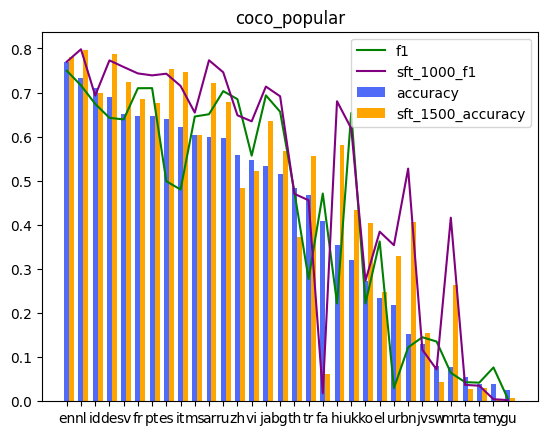

In [21]:
draw()